In [3]:
# Conectando el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive





**Implementación HOG + Coocurrecia + Tamura librerías**

In [4]:
# Crear una lista de todas las categorías (nombres de carpetas)
import os
from PIL import Image
import numpy as np
from google.colab import output
import matplotlib.pyplot as plt
import time


# Ruta al directorio donde deseas extraer el conjunto de datos
extracted_dir = '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 11y12/'

extracted_dir = os.path.join(extracted_dir, 'sentimientos/')
categories = os.listdir(extracted_dir)

# Crear diccionario para mapear etiquetas a índices
label_to_index = {category: i for i, category in enumerate(categories)}

# Inicializar listas para imágenes y etiquetas
images = []
labels = []

# Recorrer todas las categorías
for category in categories:
    category_dir = os.path.join(extracted_dir, category)
    for filename in os.listdir(category_dir):
        image_path = os.path.join(category_dir, filename)
        image = Image.open(image_path)
        #plt.imshow(image,vmin=0,vmax=255)
        #plt.show()
        #time.sleep(0.5)
        images.append(np.resize(np.array(image),[600,600,3])) #Cambio de tamaño
        labels.append(label_to_index[category]) #
        output.clear()

# Convierte las listas en matrices numpy
images = np.array(images)
labels = np.array(labels)

In [1]:
##Extracción de características
import cv2
from google.colab import output
import numpy as np
from skimage.feature import graycoprops
from skimage.feature import graycomatrix as Co_ocurrencia
import matplotlib.pyplot as plt #Para graficar
from skimage.feature import hog
from skimage import exposure

#------------------------------------------
Ruta_dataset = '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/Semana 11y12/IMG'
Filas = 600
Columnas = 600

Longitud = 1176 #Número de características de HOGs
nImagenes = 1744 #Cant de imagenes en la carpeta

# Aplicando el proceso a todas las imágenes (Tomando regiones de los rostros)
# Matriz_Características = np.zeros((nImagenes, Longitud + 12)) #Hogs + CoO + etiqueta
#------------------------------------------

X = np.zeros((len(images),Longitud + 12)) # Vector de características de HOG y CoOcurrencia
Y = np.zeros((len(images),1)) # Vector de etiquetas, aunque ya se tiene, le pongo otro nombre

for k in range(len(images)):

  Y[k] = labels[k]

  #Preprocesamiento
  Imgr = cv2.cvtColor(images[k], cv2.COLOR_BGR2GRAY)
  I_gris=cv2.resize(Imgr, (Filas,Columnas), interpolation = cv2.INTER_AREA)
  Recorte = cv2.resize(np.uint8(I_gris), (160,160))

  #HOG
  Vector_Hog, HOG_IMG = hog(Recorte, orientations = 6, pixels_per_cell=(20, 20),cells_per_block=(2, 2), visualize=True)

  #Matriz de coocurrencia
  glcm = Co_ocurrencia(Recorte, [1,2,3,4,5,6,7,8,9,10], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
  max_prob = np.max(glcm)

  # Almacenando resultados
  X[k,0:Longitud] = Vector_Hog
  X[k,Longitud] = np.mean(graycoprops(glcm, 'contrast'))
  X[k,Longitud+1] = np.mean(graycoprops(glcm, 'dissimilarity'))
  X[k,Longitud+2] = np.mean(graycoprops(glcm, 'homogeneity'))
  X[k,Longitud+3] = np.mean(graycoprops(glcm, 'ASM'))
  X[k,Longitud+4] = np.mean(graycoprops(glcm, 'energy'))
  X[k,Longitud+5] = np.mean(graycoprops(glcm, 'correlation'))
  X[k,Longitud+6] = np.std(glcm) #rugosity
  X[k,Longitud+7:Longitud+11] = np.argwhere(glcm == max_prob)[0] #directionality

NameError: name 'images' is not defined

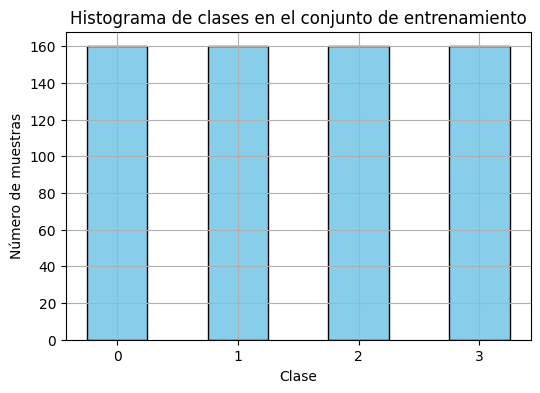

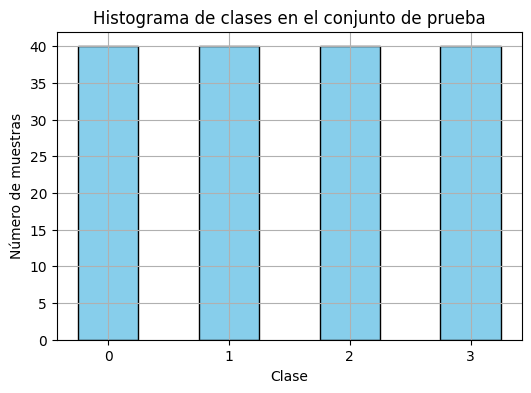

In [ ]:
#Ojo, modificación para dividir los datos garantizando el balanceo de clases
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

Indices = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in Indices.split(X, Y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Dibujar el histograma del vector test de salida
hist_train, bins = np.histogram(Y_train, bins=[0,1,2,3,4])
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist_train, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases en el conjunto de entrenamiento')
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()


# Dibujar el histograma del vector test de salida
hist_test, bins = np.histogram(Y_test, bins=[0,1,2,3,4])
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist_test, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases en el conjunto de prueba')
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()

In [ ]:
#Implementando un clasificador por comparación (KNN)
from sklearn.neighbors import KNeighborsClassifier as KNN

# Inicializar el clasificador KNN
Modelo_knn = KNN(n_neighbors=4)

# Entrenar el clasificador KNN con el conjunto de entrenamiento
Modelo_knn.fit(X_train_normalized, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=4)

In [ ]:
#Métricas de evaluación
from sklearn.metrics import accuracy_score
Y_pred = Modelo_knn.predict(X_test_normalized)

# Calcular la precisión del modelo
accuracy = accuracy_score(Y_test, Y_pred)
print("Precisión del modelo KNN:", accuracy)

Precisión del modelo KNN: 0.25625


Precisión del modelo KNN: 0.26




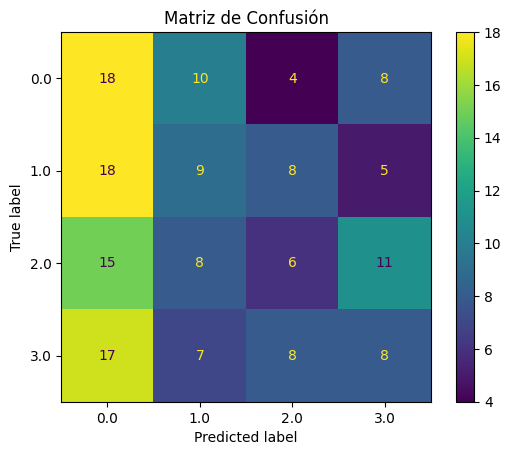


Classification Report:

              precision    recall  f1-score   support

         0.0       0.26      0.45      0.33        40
         1.0       0.26      0.23      0.24        40
         2.0       0.23      0.15      0.18        40
         3.0       0.25      0.20      0.22        40

    accuracy                           0.26       160
   macro avg       0.25      0.26      0.25       160
weighted avg       0.25      0.26      0.25       160




In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import accuracy_score

# Calcular la precisión del modelo
Y_pred = Modelo_knn.predict(X_test_normalized)
accuracy = accuracy_score(Y_test, Y_pred)

# Matriz
cm = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

# Mostrar resultados
print(f"Precisión del modelo KNN: {accuracy:.2f}\n\n==================\n")

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Modelo_knn.classes_)
disp.plot()
# disp.plot(cmap=plt.cm.Purples)
plt.title('Matriz de Confusión')
plt.show()
print(f'==================\n\nClassification Report:\n\n{report}\n\n==================')
